In [23]:

import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch")
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}")
import sys,pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
import nibabel as nib

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)


def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        print(f"run={run}")
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000,
                                 multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)

    return np.mean(accs)

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

# tmpFile = sys.argv[1]
tmpFile = "./tmp__folder/0119173_25_schaefer2018_neurosketch_11_0" 
print(f"tmpFile={tmpFile}")
[_topN,subject,dataSource,roiloc,N] = load_obj(tmpFile)
_topN=('225.nii.gz',
     '232.nii.gz',
     '108.nii.gz',
     '107.nii.gz',
     '238.nii.gz',
     '190.nii.gz',
     '138.nii.gz',
     '221.nii.gz',
     '280.nii.gz',
     '243.nii.gz')

[bcvar,runs] = load_obj(f"./tmp__folder/{subject}_{dataSource}_{roiloc}_{N}")
_mask=getMask(_topN,subject) ; print('mask dimensions: {}'. format(_mask.shape)) ; print('number of voxels in mask: {}'.format(np.sum(_mask)))
_runs = [runs[:,:,_mask==1]] ; print("Runs shape", _runs[0].shape)

# [_runs,bcvar] = load_obj(tmpFile)
sl_result = Class(_runs, bcvar)

# np.save(tmpFile+'_result',sl_result)

print(f"sl_result={sl_result}")

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_11_0


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 3294
Runs shape (6, 80, 3294)
(6, 80, 3294)
run=0
run=1
run=2
run=3
run=4
run=5
sl_result=0.33125


In [32]:
bcvar[0][0]

['bed',
 'bench',
 'chair',
 'table',
 'table',
 'bench',
 'bed',
 'chair',
 'table',
 'bench',
 'bed',
 'chair',
 'chair',
 'bed',
 'table',
 'bench',
 'bed',
 'bench',
 'chair',
 'table',
 'table',
 'bed',
 'bench',
 'chair',
 'bed',
 'chair',
 'table',
 'bench',
 'table',
 'bed',
 'bench',
 'chair',
 'bench',
 'table',
 'chair',
 'bed',
 'table',
 'bench',
 'chair',
 'bed',
 'bench',
 'bed',
 'table',
 'chair',
 'bed',
 'chair',
 'bench',
 'table',
 'chair',
 'bench',
 'bed',
 'table',
 'bench',
 'bed',
 'table',
 'chair',
 'table',
 'bench',
 'chair',
 'bed',
 'bench',
 'bed',
 'table',
 'chair',
 'bench',
 'bed',
 'table',
 'chair',
 'chair',
 'bed',
 'table',
 'bench',
 'chair',
 'bench',
 'bed',
 'table',
 'bench',
 'table',
 'chair',
 'bed']

In [3]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask
for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)


'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
subject= '0119173' #sys.argv[1]
sub_id = [i for i,x in enumerate(subjects) if x == subject][0]

print("best 4way classifier accuracy = ",GreedyBestAcc[subject][bestID[subject]])
'''
purpose: 
    train offline models

steps:
    load preprocessed and aligned behavior and brain data 
    select data with the wanted pattern like AB AC AD BC BD CD 
    train correspondng classifier and save the classifier performance and the classifiers themselves.

'''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression

def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def get_inds(X, Y, pair, testRun=None):

    inds = {}

    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label

    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                            multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]

    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X

    return inds

if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
else:
    main_dir='/Users/kailong/Desktop/rtTest'

working_dir=main_dir
os.chdir(working_dir)

objects = ['bed', 'bench', 'chair', 'table']


if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"

# print('mask dimensions: {}'. format(mask.shape))
# print('number of voxels in mask: {}'.format(np.sum(mask)))
phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
# Compile preprocessed data and corresponding indices
metas = []
for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]

    # Build the path for the preprocessed functional data
    this4d = funcdata.format(run=run, phase=phase, sub=subject)

    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]

    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)

    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()

    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
    features = np.array(features)
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
    features = normalize(features)
    # features = np.expand_dims(features, 0)

    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t if run==1 else pd.concat([behav_data,t])

    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()
brain_data = runs
print(brain_data.shape)
print(behav_data.shape)
FEAT=brain_data
print(f"FEAT.shape={FEAT.shape}")
META=behav_data

def Class(brain_data,behav_data):
    accs = []
    for run in range(1,7):
        trainIX = behav_data['run_num']!=int(run)
        testIX = behav_data['run_num']==int(run)

        trainX =  brain_data[trainIX]
        trainY =  behav_data.iloc[np.asarray(trainIX)].label

        testX =  brain_data[testIX]
        testY =  behav_data.iloc[np.asarray(testIX)].label

        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    accs
    return np.mean(accs)
accs=Class(brain_data,behav_data)
print(f"new trained 4 way classifier accuracy={accs}")

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:153: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


best 4way classifier accuracy =  0.33125
np.sum(chosenMask)=3294
1--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
2--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
5--LENGTH OF TR: 80
shape of features (80, 3294) shape of chosenMask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


shape of features (80, 3294) shape of chosenMask (94, 94, 72)
(480, 3294)
(480, 2)
FEAT.shape=(480, 3294)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


new trained 4 way classifier accuracy=0.2416666666666667


In [39]:

for run in range(6):
    t=brain_data[run*80:(run+1)*80,:]
    t=np.expand_dims(t,0)
    a= t if run == 0 else  np.concatenate((a, t))
a=[a]

b=[]
for run in range(6):
    b.append(list(behav_data[behav_data['run_num']==(run+1)].label))
b=[b]

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        print(f"run={run}")
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000,
                                 multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)

    return np.mean(accs)
Class(a,b)

(6, 80, 3294)
run=0
run=1
run=2
run=3
run=4
run=5


0.33125

In [79]:

for run in range(6):
    t=brain_data[run*80:(run+1)*80,:]
    t=np.expand_dims(t,0)
    a= t if run == 0 else  np.concatenate((a, t))
a=[a]

b=[]
for run in range(6):
    b.append(list(behav_data[behav_data['run_num']==(run+1)].label))
b=[b]

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        print(f"run={run}")
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[meta])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000,
                                 multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)

    return np.mean(accs)
print(Class(a,b))


def Class(brain_data,behav_data):
    accs = []
    for run in range(1,7):
        trainIX = behav_data['run_num']!=int(run)
        testIX = behav_data['run_num']==int(run)

        trainX =  brain_data[trainIX]
        trainY =  behav_data[np.asarray(trainIX)].label

        testX =  brain_data[testIX]
        testY =  behav_data[np.asarray(testIX)].label

        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)

        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    accs
    return np.mean(accs)
accs=Class(brain_data,behav_data)
print(f"new trained 4 way classifier accuracy={accs}")

(6, 80, 3294)
run=0
run=1
run=2
run=3
run=4
run=5
0.2416666666666667
new trained 4 way classifier accuracy=0.2416666666666667


In [78]:

for run in range(6):
    t=brain_data[run*80:(run+1)*80,:]
    t=np.expand_dims(t,0)
    a= t if run == 0 else  np.concatenate((a, t))
a=[a]

b=[]
for run in range(6):
    b.append(list(behav_data[behav_data['run_num']==(run+1)].label))
b=[b]

data, bcvar=a,b
metas = bcvar[0]
data4d = data[0]
print(data4d.shape)

accs = []
for run in range(6):
    print(f"run={run}")
    testX = data4d[run]
    testY = metas[run]
    trainX = data4d[np.arange(6) != run]
    trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
    trainY = []
    for meta in range(6):
        if meta != run:
            trainY.extend(metas[meta])
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000,
                             multi_class='multinomial').fit(trainX, trainY)

    # Monitor progress by printing accuracy (only useful if you're running a test set)
    acc = clf.score(testX, testY)
    accs.append(acc)
accs

(6, 80, 3294)
run=0
run=1
run=2
run=3
run=4
run=5


[0.3, 0.225, 0.1875, 0.2625, 0.2375, 0.2375]

In [76]:
# for a,b in zip(trainY,_trainY):
#     print(a==b)
run=2
behav_data['run_num']==run



,label,run_num
0,bed,1
1,bench,1
2,chair,1
3,table,1
4,table,1
...,...,...
75,chair,6
76,chair,6
77,bench,6
78,table,6


In [77]:
trainIX = behav_data['run_num']!=run
testIX = behav_data['run_num']==run
trainX =  brain_data[trainIX]
trainY =  list(behav_data[trainIX].label)

trainY


['bed',
 'bench',
 'chair',
 'table',
 'table',
 'bench',
 'bed',
 'chair',
 'table',
 'bench',
 'bed',
 'chair',
 'chair',
 'bed',
 'table',
 'bench',
 'bed',
 'bench',
 'chair',
 'table',
 'table',
 'bed',
 'bench',
 'chair',
 'bed',
 'chair',
 'table',
 'bench',
 'table',
 'bed',
 'bench',
 'chair',
 'bench',
 'table',
 'chair',
 'bed',
 'table',
 'bench',
 'chair',
 'bed',
 'bench',
 'bed',
 'table',
 'chair',
 'bed',
 'chair',
 'bench',
 'table',
 'chair',
 'bench',
 'bed',
 'table',
 'bench',
 'bed',
 'table',
 'chair',
 'table',
 'bench',
 'chair',
 'bed',
 'bench',
 'bed',
 'table',
 'chair',
 'bench',
 'bed',
 'table',
 'chair',
 'chair',
 'bed',
 'table',
 'bench',
 'chair',
 'bench',
 'bed',
 'table',
 'bench',
 'table',
 'chair',
 'bed',
 'bed',
 'table',
 'bench',
 'chair',
 'chair',
 'bench',
 'table',
 'bed',
 'bench',
 'chair',
 'table',
 'bed',
 'chair',
 'table',
 'bench',
 'bed',
 'bench',
 'bed',
 'chair',
 'table',
 'chair',
 'table',
 'bench',
 'bed',
 'bed',
 'be

In [104]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

    get the N combinations of N-1 ROIs
    retrain the model and get the accuracy for these N combinations

    get the N-1 combinations of N-2 ROIs
    retrain the model and get the accuracy for these N-1 combinations

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
# from tqdm import tqdm
import pickle
import subprocess
from subprocess import call
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''
global subject,dataSource,roiloc,N
subject="0119173" #sys.argv[1]
# dataSource,roiloc,N=sys.argv[2],sys.argv[3],int(sys.argv[4])
dataSource,roiloc,N="neurosketch","schaefer2018",25
print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"


workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
tag="tag2"
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            # result = np.load("{}/{}.npy".format(outloc, roinum))
            result = np.load(f"{outloc}/{tag}_{roinum}.npy")
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        # print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                # result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                result = np.load(f"{outloc}/{tag}_roi{roinum}_{hemi}.npy")
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        # print(topN[-1])

print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))

def normalize(X):
    from scipy.stats import zscore
    # X = X - X.mean(0)
    X = zscore(X, axis=0)
    X[np.isnan(X)]=0
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[meta])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

mask=getMask(topN, subject)

print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

# Compile preprocessed data and corresponding indices
metas = []
for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    # features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()


# Preset the variables
print("Runs shape", runs.shape)
bcvar = [metas]
save_obj([bcvar,runs],f"./tmp__folder/{subject}_{dataSource}_{roiloc}_{N}") #{len(topN)}_{i}
                 
# # Distribute the information to the searchlights (preparing it to run)
# _runs = [runs[:,:,mask==1]]
# print("Runs shape", _runs[0].shape)
# slstart = time.time()
# sl_result = Class(_runs, bcvar)
# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))
# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print(f"waiting for {tmpFile}_result.npy\n")
    return np.load(tmpFile+'_result.npy')

def numOfRunningJobs():
    # subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    randomID=str(time.time())
    # print(f"squeue -u kp578 | wc -l > squeue/{randomID}.txt")
    call(f'squeue -u kp578 | wc -l > squeue/{randomID}.txt',shell=True)
    numberOfJobsRunning = int(open(f"squeue/{randomID}.txt", "r").read())
    print(f"numberOfJobsRunning={numberOfJobsRunning}")
    return numberOfJobsRunning

if not os.path.exists(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}.pkl"):
    _runs = [runs[:,:,mask==1]]
    print("Runs shape", _runs[0].shape)
    slstart = time.time()
    sl_result = Class(_runs, bcvar)

    save_obj({"subject":subject,
    "startFromN":N,
    "currNumberOfROI":len(topN),
    "bestAcc":sl_result, # this is the sl_result for the topN, not the bestAcc, bestAcc is for the purpose of keeping consistent with others
    "bestROIs":topN},# this is the topN, not the bestROIs, bestROIs is for the purpose of keeping consistent with others
    f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}"
    )
# ./tmp__folder/0125171_40_schaefer2018_neurosketch_39.pkl
if os.path.exists(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{1}.pkl"):
    print(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_1.pkl exists")
    raise Exception('runned or running')


# N-1
def next(topN): 
    print(f"len(topN)={len(topN)}")
    print(f"topN={topN}")

    if len(topN)==1:
        return None
    else:
        try:
            allpairs = itertools.combinations(topN,len(topN)-1)
            topNs=[]
            sl_results=[]
            tmpFiles=[]
            while os.path.exists("./tmp__folder/holdon.npy"):
                time.sleep(10)
                print("sleep for 10s ; waiting for ./tmp__folder/holdon.npy to be deleted")
            # np.save("./tmp__folder/holdon",1)

            for i,_topN in enumerate(allpairs):
                tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{i}"
                print(f"tmpFile={tmpFile}")
                topNs.append(_topN)
                tmpFiles.append(tmpFile)

                if not os.path.exists(tmpFile+'_result.npy'):

                    # prepare brain data(runs) mask and behavior data(bcvar) 

                    # save_obj([_topN,subject,dataSource,roiloc,N], tmpFile)

                    print("kp2")
                    # numberOfJobsRunning = numOfRunningJobs()
                    print("kp3")
                    # while numberOfJobsRunning > 400: # 300 is not filling it up
                    #     print("kp4 300")
                    #     print("waiting 10, too many jobs running") ; time.sleep(10)
                    #     numberOfJobsRunning = numOfRunningJobs()
                    #     print("kp5")

                    # get the evidence for the current mask
                    # print(f'sbatch class.sh {tmpFile}')
                    # proc = subprocess.Popen([f'sbatch --requeue class.sh {tmpFile}'],shell=True) # sl_result = Class(_runs, bcvar) 
                    tmpFile = tmpFile #sys.argv[1]
                    print(f"tmpFile={tmpFile}")
                    # [_topN,subject,dataSource,roiloc,N] = load_obj(tmpFile)
                    # [bcvar,runs] = load_obj(f"./tmp__folder/{subject}_{dataSource}_{roiloc}_{N}") 
                    _mask=getMask(_topN,subject) ; print('mask dimensions: {}'. format(_mask.shape)) ; print('number of voxels in mask: {}'.format(np.sum(_mask)))
                    _runs = [runs[:,:,_mask==1]] ; print("Runs shape", _runs[0].shape)

                    # [_runs,bcvar] = load_obj(tmpFile)
                    sl_result = Class(_runs, bcvar)

                    np.save(tmpFile+'_result',sl_result)

                    print(f"sl_result={sl_result}")


                    # outs, errs = proc.communicate(timeout=5)
                    # print(f"outs={outs}")
                    # print(f"errs={errs}")
                    
                    print("kp6")
                else:
                    print(tmpFile+'_result.npy exists!')
            # os.remove("./tmp__folder/holdon.npy")

            sl_results=[]
            for tmpFile in tmpFiles:
                sl_result=wait(tmpFile)
                sl_results.append(sl_result)
            print(f"sl_results={sl_results}")
            print(f"max(sl_results)=={max(sl_results)}")
            maxID=np.where(sl_results==max(sl_results))[0][0]
            save_obj({"subject":subject,
            "startFromN":N,
            "currNumberOfROI":len(topN)-1,
            "bestAcc":max(sl_results),
            "bestROIs":topNs[maxID]},
            f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}"
            )
            print(f"bestAcc={max(sl_results)} For {len(topN)-1} = ./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}")
            tmpFiles=next(topNs[maxID])
        except:
            return tmpFiles
tmpFiles=next(topN)



conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
Running subject 0119173, with neurosketch as a data source, schaefer2018, starting with 25 ROIs
RESULT.shape=(300,)
len(topN)=25
topN=['225.nii.gz', '19.nii.gz', '58.nii.gz', '150.nii.gz', '232.nii.gz', '234.nii.gz', '108.nii.gz', '107.nii.gz', '102.nii.gz', '86.nii.gz', '238.nii.gz', '190.nii.gz', '230.nii.gz', '138.nii.gz', '166.nii.gz', '221.nii.gz', '265.nii.gz', '280.nii.gz', '236.nii.gz', '244.nii.gz', '167.nii.gz', '243.nii.gz', '205.nii.gz', '39.nii.gz', '271.nii.gz']


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7795
1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


2--LENGTH OF TR: 80
shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:223: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Runs shape (6, 80, 94, 94, 72)
len(topN)=25
topN=['225.nii.gz', '19.nii.gz', '58.nii.gz', '150.nii.gz', '232.nii.gz', '234.nii.gz', '108.nii.gz', '107.nii.gz', '102.nii.gz', '86.nii.gz', '238.nii.gz', '190.nii.gz', '230.nii.gz', '138.nii.gz', '166.nii.gz', '221.nii.gz', '265.nii.gz', '280.nii.gz', '236.nii.gz', '244.nii.gz', '167.nii.gz', '243.nii.gz', '205.nii.gz', '39.nii.gz', '271.nii.gz']
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_0
./tmp__folder/0119173_25_schaefer2018_neurosketch_25_0_result.npy exists!
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_1
./tmp__folder/0119173_25_schaefer2018_neurosketch_25_1_result.npy exists!
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_2
./tmp__folder/0119173_25_schaefer2018_neurosketch_25_2_result.npy exists!
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_3
./tmp__folder/0119173_25_schaefer2018_neurosketch_25_3_result.npy exists!
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketc

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7540
Runs shape (6, 80, 7540)
(6, 80, 7540)
sl_result=0.28958333333333336
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_11
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_11


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7383
Runs shape (6, 80, 7383)
(6, 80, 7383)
sl_result=0.275
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_12
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_12


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7573
Runs shape (6, 80, 7573)
(6, 80, 7573)
sl_result=0.29583333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_13
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_13


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7559
Runs shape (6, 80, 7559)
(6, 80, 7559)
sl_result=0.28750000000000003
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_14
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_14


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7507
Runs shape (6, 80, 7507)
(6, 80, 7507)
sl_result=0.28958333333333336
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_15
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_15


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7428
Runs shape (6, 80, 7428)
(6, 80, 7428)
sl_result=0.26249999999999996
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_16
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_16


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7361
Runs shape (6, 80, 7361)
(6, 80, 7361)
sl_result=0.2833333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_17
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_17


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7500
Runs shape (6, 80, 7500)
(6, 80, 7500)
sl_result=0.2854166666666667
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_18
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_18


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7575
Runs shape (6, 80, 7575)
(6, 80, 7575)
sl_result=0.2833333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_19
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_19


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7551
Runs shape (6, 80, 7551)
(6, 80, 7551)
sl_result=0.27499999999999997
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_20
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_20


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7282
Runs shape (6, 80, 7282)
(6, 80, 7282)
sl_result=0.27916666666666673
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_21
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_21


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7432
Runs shape (6, 80, 7432)
(6, 80, 7432)
sl_result=0.2625
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_22
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_22


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7484
Runs shape (6, 80, 7484)
(6, 80, 7484)
sl_result=0.28125
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_23
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_23


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7299
Runs shape (6, 80, 7299)
(6, 80, 7299)
sl_result=0.28750000000000003
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_24
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_25_24


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7516
Runs shape (6, 80, 7516)
(6, 80, 7516)
sl_result=0.28125000000000006
kp6
sl_results=[array(0.28541667), array(0.28333333), array(0.27291667), array(0.27083333), array(0.2875), array(0.2625), array(0.27708333), array(0.2875), array(0.26875), array(0.27916667), array(0.28958333), array(0.275), array(0.29583333), array(0.2875), array(0.28958333), array(0.2625), array(0.28333333), array(0.28541667), array(0.28333333), array(0.275), array(0.27916667), array(0.2625), array(0.28125), array(0.2875), array(0.28125)]
max(sl_results)==0.29583333333333334
bestAcc=0.29583333333333334 For 24 = ./tmp__folder/0119173_25_schaefer2018_neurosketch_24
len(topN)=24
topN=('225.nii.gz', '19.nii.gz', '58.nii.gz', '150.nii.gz', '232.nii.gz', '234.nii.gz', '108.nii.gz', '107.nii.gz', '102.nii.gz', '86.nii.gz', '238.nii.gz', '190.nii.gz', '138.nii.gz', '166.nii.gz', '221.nii.gz', '265.nii.gz', '280.nii.gz', '236.nii.gz', '244.nii.gz', '167.nii.gz', '24

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7385
Runs shape (6, 80, 7385)
(6, 80, 7385)
sl_result=0.2833333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_1
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_1


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7419
Runs shape (6, 80, 7419)
(6, 80, 7419)
sl_result=0.2916666666666667
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_2
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_2


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7294
Runs shape (6, 80, 7294)
(6, 80, 7294)
sl_result=0.27291666666666664
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_3
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_3


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7036
Runs shape (6, 80, 7036)
(6, 80, 7036)
sl_result=0.2708333333333333
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_4
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_4


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7313
Runs shape (6, 80, 7313)
(6, 80, 7313)
sl_result=0.29583333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_5
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_5


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7262
Runs shape (6, 80, 7262)
(6, 80, 7262)
sl_result=0.28124999999999994
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_6
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_6


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7279
Runs shape (6, 80, 7279)
(6, 80, 7279)
sl_result=0.28125
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_7
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_7


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7259
Runs shape (6, 80, 7259)
(6, 80, 7259)
sl_result=0.29375
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_8
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_8


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7250
Runs shape (6, 80, 7250)
(6, 80, 7250)
sl_result=0.2833333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_9
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_9


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7373
Runs shape (6, 80, 7373)
(6, 80, 7373)
sl_result=0.28125000000000006
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_10
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_10


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7318
Runs shape (6, 80, 7318)
(6, 80, 7318)
sl_result=0.29374999999999996
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_11
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_11


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7161
Runs shape (6, 80, 7161)
(6, 80, 7161)
sl_result=0.28958333333333336
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_12
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_12


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7337
Runs shape (6, 80, 7337)
(6, 80, 7337)
sl_result=0.2833333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_13
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_13


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7285
Runs shape (6, 80, 7285)
(6, 80, 7285)
sl_result=0.2916666666666667
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_14
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_14


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7206
Runs shape (6, 80, 7206)
(6, 80, 7206)
sl_result=0.26875000000000004
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_15
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_15


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7139
Runs shape (6, 80, 7139)
(6, 80, 7139)
sl_result=0.28750000000000003
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_16
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_16


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7278
Runs shape (6, 80, 7278)
(6, 80, 7278)
sl_result=0.28958333333333336
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_17
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_17


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7353
Runs shape (6, 80, 7353)
(6, 80, 7353)
sl_result=0.29791666666666666
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_18
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_18


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7329
Runs shape (6, 80, 7329)
(6, 80, 7329)
sl_result=0.28958333333333336
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_19
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_19


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7060
Runs shape (6, 80, 7060)
(6, 80, 7060)
sl_result=0.29375
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_20
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_20


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7210
Runs shape (6, 80, 7210)
(6, 80, 7210)
sl_result=0.27708333333333335
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_21
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_21


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7262
Runs shape (6, 80, 7262)
(6, 80, 7262)
sl_result=0.2791666666666666
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_22
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_22


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7077
Runs shape (6, 80, 7077)
(6, 80, 7077)
sl_result=0.2875
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_23
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_24_23


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7294
Runs shape (6, 80, 7294)
(6, 80, 7294)
sl_result=0.3
kp6
sl_results=[array(0.28333333), array(0.29166667), array(0.27291667), array(0.27083333), array(0.29583333), array(0.28125), array(0.28125), array(0.29375), array(0.28333333), array(0.28125), array(0.29375), array(0.28958333), array(0.28333333), array(0.29166667), array(0.26875), array(0.2875), array(0.28958333), array(0.29791667), array(0.28958333), array(0.29375), array(0.27708333), array(0.27916667), array(0.2875), array(0.3)]
max(sl_results)==0.3
bestAcc=0.3 For 23 = ./tmp__folder/0119173_25_schaefer2018_neurosketch_23
len(topN)=23
topN=('19.nii.gz', '58.nii.gz', '150.nii.gz', '232.nii.gz', '234.nii.gz', '108.nii.gz', '107.nii.gz', '102.nii.gz', '86.nii.gz', '238.nii.gz', '190.nii.gz', '138.nii.gz', '166.nii.gz', '221.nii.gz', '265.nii.gz', '280.nii.gz', '236.nii.gz', '244.nii.gz', '167.nii.gz', '243.nii.gz', '205.nii.gz', '39.nii.gz', '271.nii.gz')
tmpFile=./tmp__fol

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7106
Runs shape (6, 80, 7106)
(6, 80, 7106)
sl_result=0.3
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_1
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_1


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7140
Runs shape (6, 80, 7140)
(6, 80, 7140)
sl_result=0.29791666666666666
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_2
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_2


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7015
Runs shape (6, 80, 7015)
(6, 80, 7015)
sl_result=0.2833333333333333
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_3
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_3


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 6757
Runs shape (6, 80, 6757)
(6, 80, 6757)
sl_result=0.275
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_4
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_4


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7034
Runs shape (6, 80, 7034)
(6, 80, 7034)
sl_result=0.3083333333333333
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_5
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_5


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 6983
Runs shape (6, 80, 6983)
(6, 80, 6983)
sl_result=0.2833333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_6
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_6


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7000
Runs shape (6, 80, 7000)
(6, 80, 7000)
sl_result=0.28541666666666665
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_7
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_7


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 6980
Runs shape (6, 80, 6980)
(6, 80, 6980)
sl_result=0.28958333333333336
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_8
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_8


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 6971
Runs shape (6, 80, 6971)
(6, 80, 6971)
sl_result=0.2875
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_9
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_9


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7094
Runs shape (6, 80, 7094)
(6, 80, 7094)
sl_result=0.29583333333333334
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_10
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_10


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7039
Runs shape (6, 80, 7039)
(6, 80, 7039)
sl_result=0.29791666666666666
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_11
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_11


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 6882
Runs shape (6, 80, 6882)
(6, 80, 6882)
sl_result=0.28541666666666665
kp6
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_12
kp2
kp3
tmpFile=./tmp__folder/0119173_25_schaefer2018_neurosketch_23_12


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:180: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 7058
Runs shape (6, 80, 7058)
(6, 80, 7058)


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
{'1206161': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '0119173': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '1206162': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '1130161': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '1206163': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '0120171': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '0111171': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '1202161': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], '0125172': [25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning: Mean of empty slice


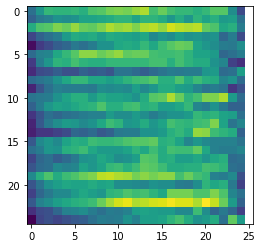

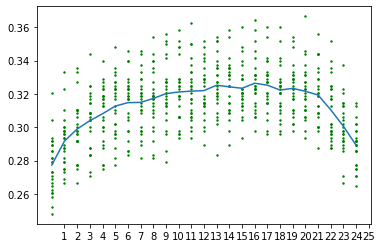

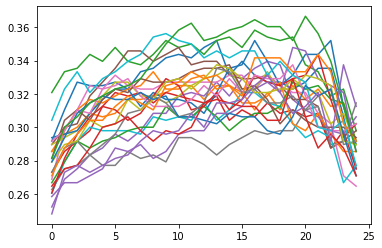

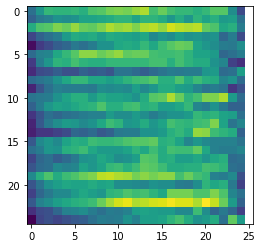

In [140]:

'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    for len_topN in range(N-1,0,-1):
#     for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp_folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
print(numberOfROIs)
# GreedyBestAcc=GreedyBestAcc.T
_GreedyBestAcc=np.zeros((len(subjects),N+1))
_GreedyBestAcc[_GreedyBestAcc==0]=None
for ii,sub in enumerate(GreedyBestAcc):
    _GreedyBestAcc[ii,0:len(GreedyBestAcc[sub])]=GreedyBestAcc[sub]
    if len(GreedyBestAcc[sub])<5:
        print(f"sbatch --requeue aggregate_greedy.sh {sub} neurosketch schaefer2018 25")
plt.imshow(_GreedyBestAcc)

_=plt.figure()
for j in range(_GreedyBestAcc.shape[1]):
    plt.scatter([j]*_GreedyBestAcc.shape[0],_GreedyBestAcc[:,j],c='g',s=2)
plt.plot(np.arange(_GreedyBestAcc.shape[1]),np.nanmean(_GreedyBestAcc,axis=0))
plt.xticks(numberOfROIs['0112173'])

# plt.ylim([0.19,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")
_=plt.figure()
for j in range(_GreedyBestAcc.shape[0]):
    plt.plot(_GreedyBestAcc[j,:])



_=plt.figure()
plt.imshow(_GreedyBestAcc)